In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier,DeterministicProcess


In [20]:
store_sales = pd.read_csv("./train.csv",
                          usecols=['store_nbr','family','date','sales','onpromotion'],
                          dtype={
                              'store_nbr' : 'category',
                              'family': 'category',
                              'sales': 'float32',
                              'onpromotion' : 'uint32',
                          },
                          parse_dates=['date'],
                          infer_datetime_format = True,
                          )
store_sales.head()

C:\Users\91972\AppData\Local\Temp\ipykernel_19496\3857428180.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv("./train.csv",


,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [21]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [22]:
store_sales = store_sales.set_index(['store_nbr','family','date']).sort_index()
store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [23]:
family_sales = (
    store_sales.groupby(['family','date']).mean().unstack('family')
    .loc['2017',['sales','onpromotion']]
)
family_sales.head()

C:\Users\91972\AppData\Local\Temp\ipykernel_19496\1535689133.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_sales.groupby(['family','date']).mean().unstack('family')


sales            ...                onpromotion          
family     AUTOMOTIVE BABY CARE  ... SCHOOL AND OFFICE SUPPLIES   SEAFOOD
date                             ...                                     
2017-01-01   0.092593  0.037037  ...                        0.0  0.000000
2017-01-02  11.481482  0.259259  ...                        0.0  0.407407
2017-01-03   8.296296  0.296296  ...                        0.0  0.407407
2017-01-04   6.833333  0.333333  ...                        0.0  0.333333
2017-01-05   6.333333  0.351852  ...                        0.0  0.444444

[5 rows x 66 columns]

In [24]:
print(family_sales.columns.levels[1])


CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'], ordered=False, dtype='category', name='family')


In [25]:
supply_sales= family_sales.loc(axis=1)[:,'SCHOOL AND OFFICE SUPPLIES']
supply_sales.head()

,sales,onpromotion
family,SCHOOL AND OFFICE SUPPLIES,SCHOOL AND OFFICE SUPPLIES
date,,
2017-01-01,0.000000,0.0
2017-01-02,2.925926,0.0
2017-01-03,2.018518,0.0
2017-01-04,1.722222,0.0
2017-01-05,1.425926,0.0


In [26]:
y = supply_sales.loc[:,'sales'].squeeze()
y.head()

date
2017-01-01    0.000000
2017-01-02    2.925926
2017-01-03    2.018518
2017-01-04    1.722222
2017-01-05    1.425926
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, dtype: float32

In [27]:
fourier = CalendarFourier(freq='M' , order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order= 1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time.head()

c:\Users\91972\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


In [28]:
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

Text(0.5, 1.0, 'Sales of School and Office Supplies (deseasonalized)')

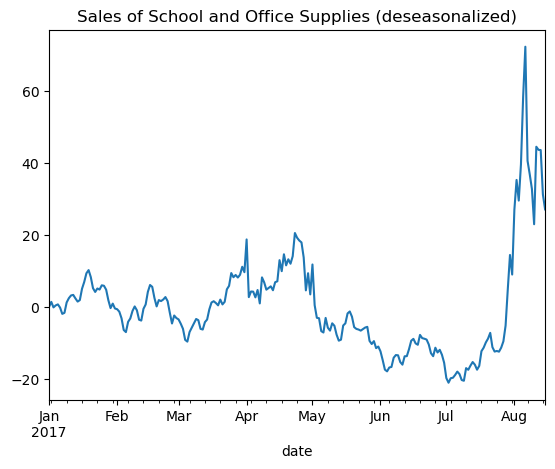

In [29]:
model = LinearRegression(fit_intercept=False)
model.fit(X_time,y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sale_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)")

Text(0.5, 1.0, 'sevenday moving average')

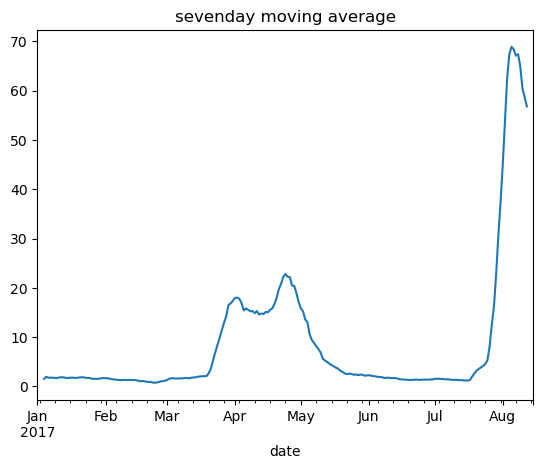

In [31]:
y_ma = y.rolling(7, center=True).mean()

ax = y_ma.plot()
ax.set_title("sevenday moving average")

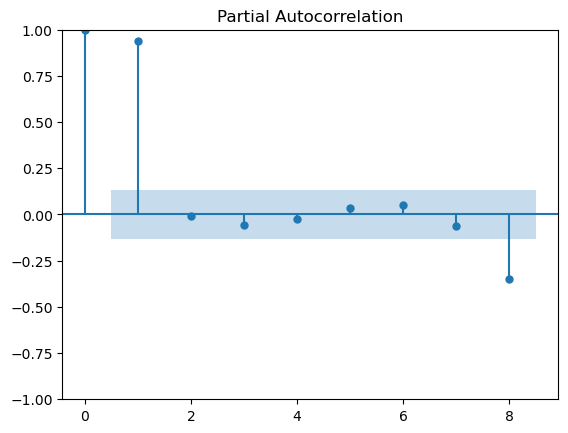

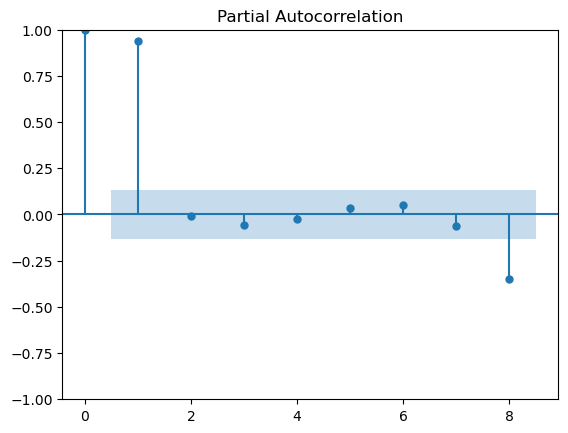

In [36]:
plot_pacf(y_deseason, lags=8)